In [1]:
#@title Mount files locally. Get token from https://dashboard.ngrok.com/auth
from carsmoney import authenticate
from carsmoney import pipelines
import carsmoney
import os
from torchvision import transforms
from PIL import Image
import torch
import matplotlib.pyplot as plt
import numpy as np
import cv2

#carsmoney.reset()

In [2]:
segmentation = pipelines.segmentation()
segmentation.build_model(save_path="pretrained_unet.pt")


FileNotFoundError: [Errno 2] No such file or directory: 'pretrained_unet.pt'

In [3]:
!ls test_images | head

resizeID_000372ced.jpg
resizeID_0003b03e8.jpg
resizeID_001c3cc69.jpg
resizeID_002c9d7ed.jpg
resizeID_003124d34.jpg
resizeID_00430e015.jpg
resizeID_004317e79.jpg
resizeID_004929246.jpg
resizeID_004969cd0.jpg
resizeID_00953012a.jpg
ls: write error: Broken pipe


In [ ]:
dirs = "test_images/"
aa = os.listdir(dirs)
for a in aa:
    image = Image.open("test_images/" + a)

    image = transforms.ToTensor()(image)
    i = image.numpy()
    image = torch.stack((image,), dim=0).cuda()

    result = segmentation.model(image).detach().cpu().numpy()
    mask = "test_masks/" + a
    if os.path.isfile(mask):
        mask = Image.open("test_masks/" + a)
        m = np.max(np.array(mask), axis=2) < 100
        image = np.rot90((m*i/(1 + np.exp(-result[0,1,:,:]))).T, k=3)
    else:
        image = np.rot90((i/(1 + np.exp(-result[0,1,:,:]))).T, k=3)
    cv2.imwrite("processed/"+a, cv2.cvtColor((image * 255), cv2.COLOR_RGB2BGR))
    print(a)
    break


In [ ]:

#
x = np.linspace(2*np.sqrt(3), 0., 256)
y = np.linspace(3*np.sqrt(3), 0., 384)
data = np.hstack([np.reshape(i, (-1, 3)), np.array(np.meshgrid(x, y)).T.reshape(-1,2)])[np.reshape(result[0,1,:,:] > 0, -1) * np.reshape(m,(-1)), :]

In [ ]:
params = cv2.SimpleBlobDetector_Params() 

# Change thresholds
params.minThreshold = 10
params.maxThreshold = 255

# Filter by Area.
params.filterByArea = True
params.minArea = 100

# Filter by Circularity
params.filterByCircularity = False
params.minCircularity = 0.001

# Filter by Convexity
params.filterByConvexity = False
params.minConvexity = 0.5

# Filter by Inertia
params.filterByInertia = False
params.minInertiaRatio = 0.1

# Create a detector with the parameters
detector = cv2.SimpleBlobDetector_create(params)

# Detect blobs.
dirs = "test_images/"
aa = os.listdir(dirs)
for a in aa:
    image = cv2.imread("test_images/" + a)
    bloby = cv2.imread("processed/" + a)

    bloby = cv2.bitwise_not(bloby)

    keypoints = detector.detect(bloby)
    #im_with_keypoints = cv2.drawKeypoints(image, keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    #plt.imshow(im_with_keypoints)
    for i, keypoint in enumerate(keypoints):
        pts = [int(k) for k in keypoint.pt]
        h = keypoint.size * 1.2
        w = int(h/2.*3)
        h = int(h)
        cv2.imwrite("spliced/" + str(i) + a, cv2.flip(image, 1)[max(pts[1] - h, 0):pts[1] + h, max(pts[0] - w, 0):pts[0] + w])


In [84]:
!ls -l spliced | wc -l

12022


In [ ]:
def plot_features(data, labels):
  """
  input args:
    data = numpy array where rows are number of examples and columns are number of features

  
  rows are in order by features 1, 2, ...num_features-1 
  plotted against every other features that hasn't already been plotted
  e.g. row 1 is feature 1 versus 2, 1 versus 3, ...,1 versus num_features
  e.g. row 5 is features 5 versus 6, feature 6 versus 7, ..., 5 versus num_features
  """
  num_feature = data.shape[1]
  plt.figure(figsize=(num_feature*4,num_feature*4));
  for i in range(num_feature):
    for j in range(i+1,num_feature):
      plt.subplot(num_feature,num_feature,i*num_feature+j-i+1)
      plt.scatter(data[:,i],data[:,j],c=labels, label = ('feature ', (i+1), 'versus ', (j+1)))
      plt.legend()
  plt.show()


In [ ]:
def kmeans_clustering(num_cluster, data, plot_bool = False):
  print('\n\ninitializing kmeans clustering')
  kmeans = KMeans(init='random', n_clusters=num_cluster, n_init=10).fit(data)
  # list of scores from kmeans method (negative sum of distance squared from cluster center)
  cluster_label, inertia = kmeans.labels_, kmeans.inertia_

  # plots 2D slices of the features
  if plot_bool == True:
    print('plots of clusters with pseudolabels')
    plot_features(data, cluster_label)
  print('inertia is ', inertia)

  return cluster_label, inertia




initializing gmm clustering
score is  2.5140303546991714


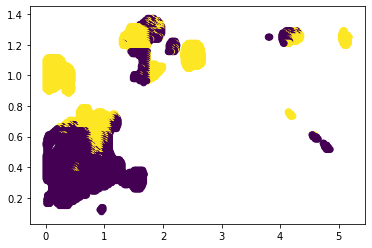



initializing gmm clustering
score is  3.675278383789454


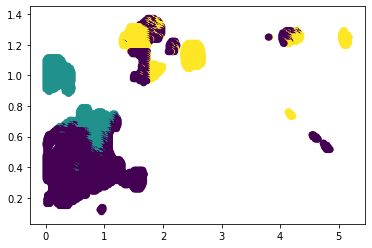



initializing gmm clustering
score is  3.592969789141655


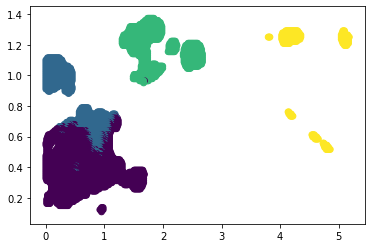



initializing gmm clustering
score is  4.764483086886848


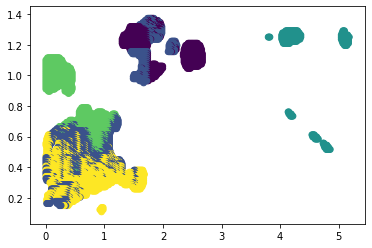



initializing gmm clustering
score is  4.8305785404621


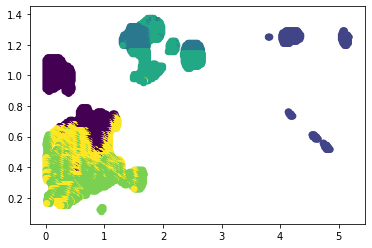



initializing gmm clustering
score is  5.438231796283592


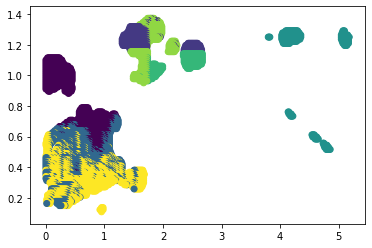



initializing gmm clustering
score is  5.58896547702057


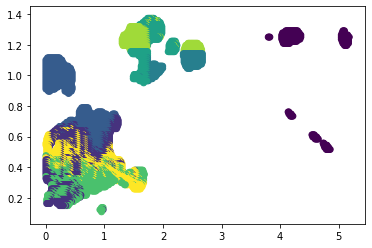



initializing gmm clustering
score is  5.773804372937468


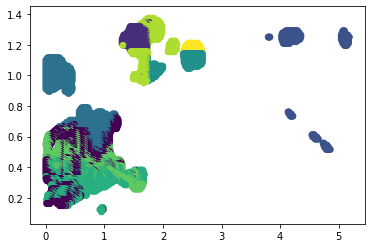



initializing gmm clustering
score is  5.9149686656992


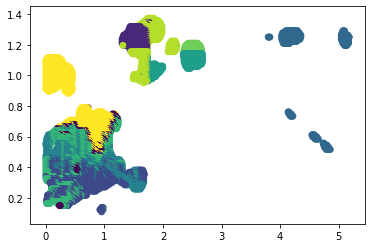



initializing gmm clustering
score is  6.078803856156501


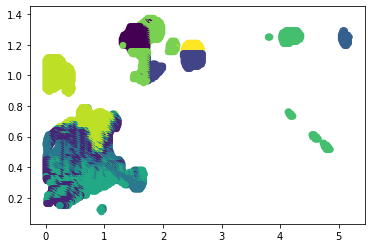



initializing gmm clustering
score is  6.199887177475897


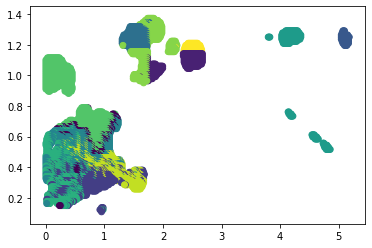



initializing gmm clustering
score is  6.319437732282277


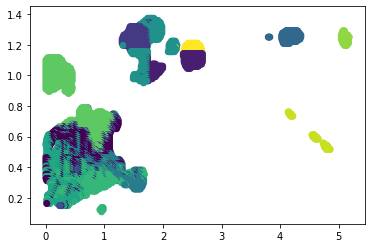



initializing gmm clustering
score is  6.379146618066142


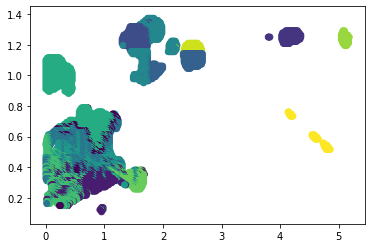



initializing gmm clustering
score is  6.463299635297446


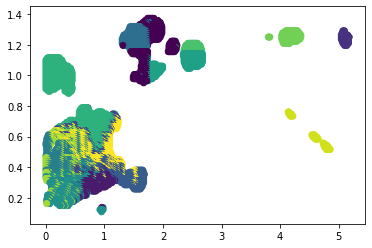



initializing gmm clustering
score is  6.5550731924067565


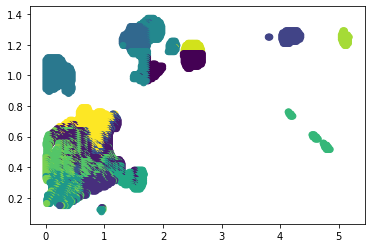



initializing gmm clustering
score is  6.65209052993573


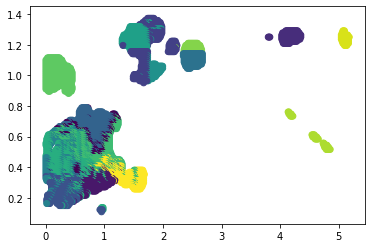



initializing gmm clustering
score is  6.714649073761654


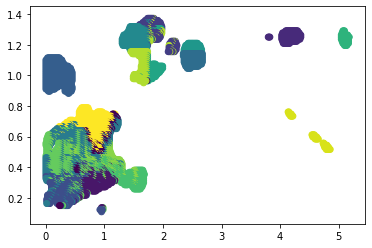



initializing gmm clustering
score is  6.792458027475964


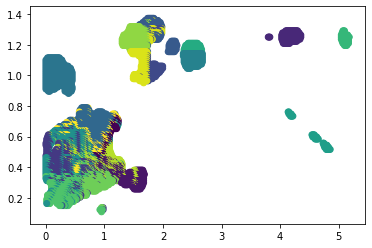

In [34]:
# Calculation Dependencies

import numpy as np
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import SpectralClustering

# Plotting Dependencies
from sklearn import datasets
import matplotlib.pyplot as plt

# Preprocessing dependencies
import csv
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# # maybe useful in future
# from sklearn.metrics import silhouette_samples, silhouette_score
# from mpl_toolkits.mplot3d import Axes3D
# from sklearn.model_selection import KFold
# import pandas as pd
# from sklearn import datasets

def gmm_clustering(num_cluster, data, plot_bool = False):
  print('\n\ninitializing gmm clustering')
  gmm = GaussianMixture(n_components=num_cluster, n_init=10).fit(data)
  cluster_label, score = gmm.predict(data), gmm.score(data)

  # plots 2D slices of the features
  if plot_bool == True:
    print('plots of clusters with pseudolabels')
    plot_features(data, cluster_label)
  print('score is ', score)

  return cluster_label, score

for i in range(2, 20):
    cl ,_ = gmm_clustering(i, data)

    reconstruction = data[:, -2:].T
    plt.scatter(reconstruction[1], reconstruction[0], c=cl)
    plt.show()
#data,